In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.stats as stats
from pandas.api.types import is_numeric_dtype
import pickle

In [2]:
df = pd.read_csv('student_final_data.csv')

In [3]:
df.head()

,Student_ID,First_Name,Last Name,Age,Gender,Library_weekly_hours,Class_weekly_attendance_percentage,Extra-curricular_weekly_hours,Previous_Exam_Score,Father_Occupation,Mother_Occupation,Parent_Income_Level
0,S001,Tunde,Ibe,16,Female,7,36.7,12,31,Doctor,Teacher,Medium
1,S002,Chinedu,Adamu,18,Male,9,41.7,7,51,Engineer,Unemployed,Medium
2,S003,Emeka,Eze,17,Male,1,31.7,9,15,Doctor,Doctor,Low
3,S004,Ibrahim,Adebayo,18,Male,7,36.7,13,29,Doctor,Farmer,High
4,S005,Ngozi,Mohammed,17,Male,5,46.7,12,35,Doctor,Civil Servant,Low


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Student_ID                          200 non-null    object 
 1   First_Name                          200 non-null    object 
 2   Last Name                           200 non-null    object 
 3   Age                                 200 non-null    int64  
 4   Gender                              200 non-null    object 
 5   Library_weekly_hours                200 non-null    int64  
 6   Class_weekly_attendance_percentage  200 non-null    float64
 7   Extra-curricular_weekly_hours       200 non-null    int64  
 8   Previous_Exam_Score                 200 non-null    int64  
 9   Father_Occupation                   200 non-null    object 
 10  Mother_Occupation                   200 non-null    object 
 11  Parent_Income_Level                 200 non-n

In [5]:
# no null entries
df.isnull().sum()

Student_ID                            0
First_Name                            0
Last Name                             0
Age                                   0
Gender                                0
Library_weekly_hours                  0
Class_weekly_attendance_percentage    0
Extra-curricular_weekly_hours         0
Previous_Exam_Score                   0
Father_Occupation                     0
Mother_Occupation                     0
Parent_Income_Level                   0
dtype: int64

In [6]:
#no duplicates
df[df.duplicated()]

,Student_ID,First_Name,Last Name,Age,Gender,Library_weekly_hours,Class_weekly_attendance_percentage,Extra-curricular_weekly_hours,Previous_Exam_Score,Father_Occupation,Mother_Occupation,Parent_Income_Level


In [7]:
# further checks of duplication from student ID
# non found
df.Student_ID.nunique() # should be 200 (length of datafrane) if all unique

200

In [8]:
# Student_ID,First_Name, and Last Name would be dropped as they dont relate to the problem at hand
# Father_Occupation and Mother_Occupation dont contain any information specific to the problem
# also column of Parent_Income_Level captures the economic value of these colums
df = df.drop(columns=['Student_ID','First_Name',"Last Name",'Father_Occupation', 'Mother_Occupation'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 200 non-null    int64  
 1   Gender                              200 non-null    object 
 2   Library_weekly_hours                200 non-null    int64  
 3   Class_weekly_attendance_percentage  200 non-null    float64
 4   Extra-curricular_weekly_hours       200 non-null    int64  
 5   Previous_Exam_Score                 200 non-null    int64  
 6   Parent_Income_Level                 200 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 11.1+ KB


In [10]:
# examine numeric columns
# nothing seems out of place so far apart from the minimum age
df.describe()

,Age,Library_weekly_hours,Class_weekly_attendance_percentage,Extra-curricular_weekly_hours,Previous_Exam_Score
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,16.875000,5.105000,46.801500,7.890000,41.605000
std,1.367011,2.895843,12.440356,4.439193,16.839442
min,11.000000,0.000000,25.000000,0.000000,1.000000
25%,16.000000,2.000000,35.000000,4.000000,31.000000
50%,17.000000,5.000000,46.700000,8.000000,43.000000
75%,18.000000,7.000000,60.000000,12.000000,51.000000
max,20.000000,10.000000,66.700000,15.000000,85.000000


In [11]:
# examine categorical columns
# we might need to exclude ages with minimal entries (11,14,20)
df['Age'].value_counts()

Age
17    50
16    48
18    41
15    32
19    26
14     1
11     1
20     1
Name: count, dtype: int64

In [12]:
# examine categorical columns
df['Gender'].value_counts()

Gender
Male      110
Female     90
Name: count, dtype: int64

In [13]:
# examine categorical columns
df['Parent_Income_Level'].value_counts()

Parent_Income_Level
High      80
Medium    63
Low       57
Name: count, dtype: int64

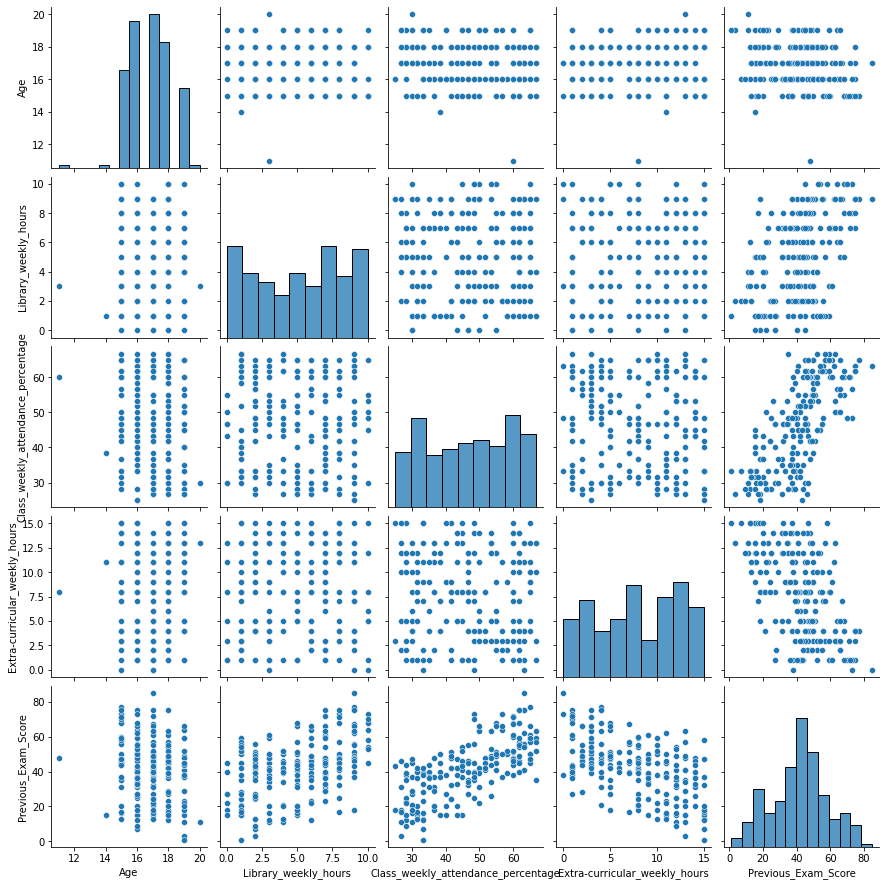

In [14]:
# lets visualize the data
sns.pairplot(df)

## Examine the data for outliers

In [15]:
# examining age further 
df['Age'].value_counts()

Age
17    50
16    48
18    41
15    32
19    26
14     1
11     1
20     1
Name: count, dtype: int64

In [16]:
# lets remove the ages 11,14,20 as there are only 1 entries each
# we also dont intend on creating bins for this
df_no_outliers = df[(df['Age'] != 11) & (df['Age'] != 14) & (df['Age'] != 20)]

In [17]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 197 non-null    int64  
 1   Gender                              197 non-null    object 
 2   Library_weekly_hours                197 non-null    int64  
 3   Class_weekly_attendance_percentage  197 non-null    float64
 4   Extra-curricular_weekly_hours       197 non-null    int64  
 5   Previous_Exam_Score                 197 non-null    int64  
 6   Parent_Income_Level                 197 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 12.3+ KB


In [18]:
# Examining other numeric columns

In [19]:
def calculate_outlier_bounds(df):
    # Dictionary to store bounds for each column
    bounds = {}

    # Loop through each numeric column
    excluded_columns = ['age']
    
    for col in (col for col in df.select_dtypes(include=['int64']).columns if col not in excluded_columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds for the current column
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Store the bounds for this column
        bounds[col] = (lower_bound, upper_bound)

    return bounds

def apply_outlier_bounds(df, bounds):
    # Start with a copy of the original DataFrame
    df_filtered = df.copy()

    # Apply the bounds for each column
    for col, (lower_bound, upper_bound) in bounds.items():
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    
    return df_filtered

# Calculate the outlier bounds for each numeric column
outlier_bounds = calculate_outlier_bounds(df)

# Apply the calculated bounds to filter out outliers
df_no_outliers = apply_outlier_bounds(df_no_outliers, outlier_bounds)



In [20]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 196 non-null    int64  
 1   Gender                              196 non-null    object 
 2   Library_weekly_hours                196 non-null    int64  
 3   Class_weekly_attendance_percentage  196 non-null    float64
 4   Extra-curricular_weekly_hours       196 non-null    int64  
 5   Previous_Exam_Score                 196 non-null    int64  
 6   Parent_Income_Level                 196 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 12.2+ KB


In [21]:
df_no_outliers.describe()

,Age,Library_weekly_hours,Class_weekly_attendance_percentage,Extra-curricular_weekly_hours,Previous_Exam_Score
count,196.000000,196.000000,196.000000,196.000000,196.000000
mean,16.903061,5.127551,46.779082,7.887755,41.642857
std,1.279339,2.889247,12.402784,4.428075,16.464570
min,15.000000,0.000000,25.000000,0.000000,1.000000
25%,16.000000,2.000000,35.000000,4.000000,31.000000
50%,17.000000,5.000000,46.700000,8.000000,43.000000
75%,18.000000,7.000000,58.725000,12.000000,51.000000
max,19.000000,10.000000,66.700000,15.000000,77.000000


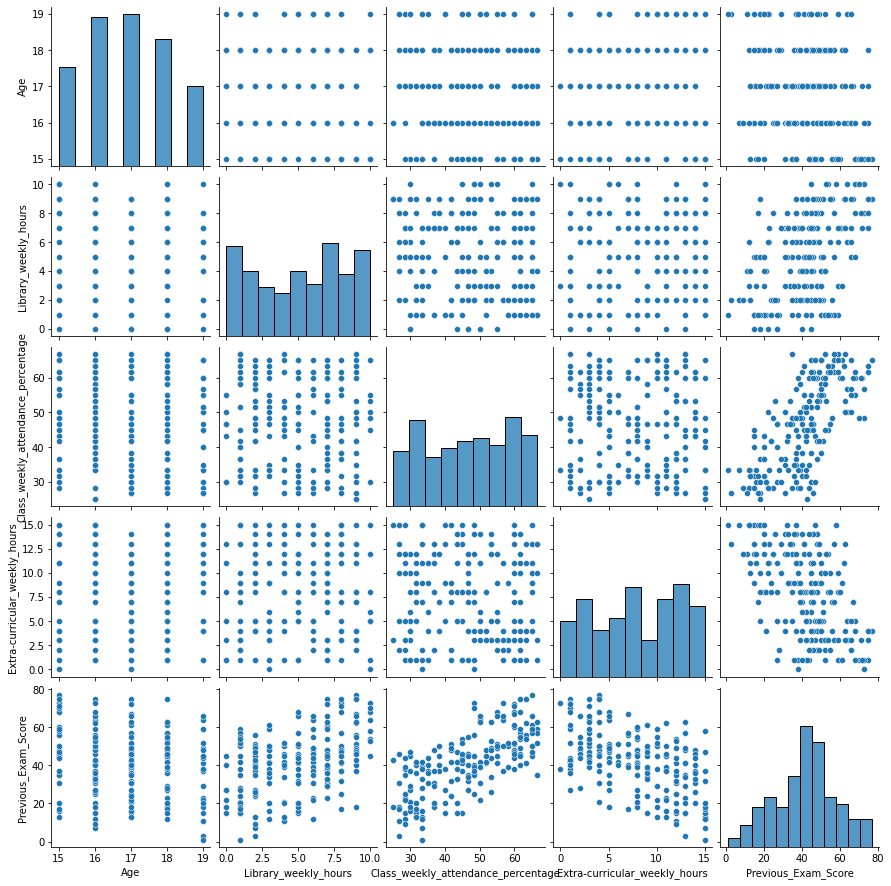

In [22]:
sns.pairplot(df_no_outliers)

## lets analyze for feature selection

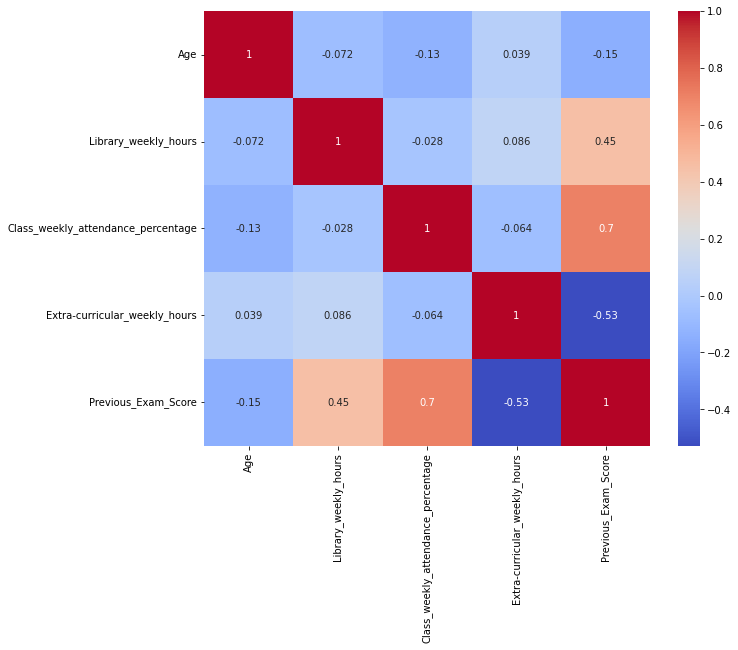

In [23]:
corr = df_no_outliers.drop(columns=['Parent_Income_Level','Gender']).corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [24]:
# the numeric columns except have a medium to good relationship with the examscore
# however age has a weak relationsip it would be removed if overfitting occurs
# none of the features are correlated with themselves so they are suitable for linear regression if need be
# also a significance test would be used to further aid feature selection

In [25]:
#lets carry out a significance test for further feature selection

In [26]:
dependent_var = 'Previous_Exam_Score'

# List of independent variables
independent_vars = [col for col in df_no_outliers.columns if col != dependent_var]

# Initialize a list to store results
results = []

for var in independent_vars:
    if is_numeric_dtype(df_no_outliers[var]):
        # Numerical variable: Perform Pearson correlation
        r_value, p_value = stats.pearsonr(df_no_outliers[var], df_no_outliers[dependent_var])
        results.append({
            'Variable': var,
            'Test': 'Pearson correlation',
            'Statistic': r_value,
            'p-value': p_value
        })
    else:
        # Categorical variable
        categories = df_no_outliers[var].unique()
        if len(categories) == 2:
            # Two categories: Perform independent t-test
            group1 = df_no_outliers[df_no_outliers[var] == categories[0]][dependent_var]
            group2 = df_no_outliers[df_no_outliers[var] == categories[1]][dependent_var]
            t_stat, p_value = stats.ttest_ind(group1, group2)
            results.append({
                'Variable': var,
                'Test': 'Independent t-test',
                'Statistic': t_stat,
                'p-value': p_value
            })
        else:
            # More than two categories: Perform one-way ANOVA
            groups = [df_no_outliers[df_no_outliers[var] == category][dependent_var] for category in categories]
            f_stat, p_value = stats.f_oneway(*groups)
            results.append({
                'Variable': var,
                'Test': 'One-way ANOVA',
                'Statistic': f_stat,
                'p-value': p_value
            })


In [27]:
# Convert the results to a DataFrame and display
results_df = pd.DataFrame(results)
results_df

,Variable,Test,Statistic,p-value
0,Age,Pearson correlation,-0.151624,3.388485e-02
1,Gender,Independent t-test,-0.589755,5.560412e-01
2,Library_weekly_hours,Pearson correlation,0.454597,2.184568e-11
3,Class_weekly_attendance_percentage,Pearson correlation,0.701942,2.078216e-30
4,Extra-curricular_weekly_hours,Pearson correlation,-0.528381,1.729014e-15
5,Parent_Income_Level,One-way ANOVA,0.189661,8.273937e-01


In [28]:
# from this analysis only age, Library_weekly_hours,Class_weekly_attendance_percentage, and Extra-curricular_weekly_hours have a statistically significant relationship with exam performance
# these are the features that would be used for modelling
# is critical performance issue arrive due to underfitting then these might be brought in

In [29]:
df_no_outliers=df_no_outliers.drop(columns=['Gender','Parent_Income_Level'])

## model selection

In [30]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 196 non-null    int64  
 1   Library_weekly_hours                196 non-null    int64  
 2   Class_weekly_attendance_percentage  196 non-null    float64
 3   Extra-curricular_weekly_hours       196 non-null    int64  
 4   Previous_Exam_Score                 196 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 9.2 KB


In [31]:
# separate predictors from the target
X_clean = df_no_outliers.drop(columns = ['Previous_Exam_Score'])
y_clean = df_no_outliers['Previous_Exam_Score']

In [32]:
# train test split
X_clean_train, X_clean_test, y_clean_train, y_clean_test = train_test_split(X_clean, y_clean, test_size = 0.1, random_state=3)

In [33]:
# set up kfold for cross validation
# high number of splits was chosen due to a smaller dataset
kf = KFold(n_splits=20, shuffle=True, random_state=3)

In [34]:
# since some of the variables have a somewhat strong correlation with the target and an obvious trend can be seen let start out with a linear regressor

In [35]:
# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), X_clean_train.select_dtypes(include=["int64", "float64"]).columns),  # Scaling numeric features
        ])

# pipeline with the preprocessor, model and clipper
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [36]:
cv_results = cross_validate(model, X_clean_train, y_clean_train, cv=kf, 
                            return_train_score=True)

# Get average training and cross-validation scores
average_train_score = np.mean(cv_results['train_score'])
average_cv_score = np.mean(cv_results['test_score'])

average_train_score, average_cv_score

(0.9946522048815696, 0.9931125903618698)

## Hyperparameter tuning

In [37]:
# the model already performs well 
# It doesnt appear to be over or underfitting 

## Model explanation and reporting

In [38]:
model.fit(X_clean_train, y_clean_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Age', 'Library_weekly_hours', 'Class_weekly_attendance_percentage',
       'Extra-curricular_weekly_hours'],
      dtype='object'))])),
                ('model', LinearRegression())])

### mean absolute error

In [39]:
y_pred = model.predict(X_clean_test)

In [40]:
mae = mean_absolute_error(y_clean_test, y_pred)

In [41]:
print(f"Mean Absolute Error (MAE) on the test set: {mae:.2f}")

Mean Absolute Error (MAE) on the test set: 0.83


### error margin

In [42]:
y_clean_test.mean()

44.8

In [43]:
error_margin =(mae/y_clean_test.mean())

In [44]:
print(f"Margin of error on the test set: {error_margin * 100:.1f}%")

Margin of error on the test set: 1.9%


## lets explain the model

In [45]:
# we are going to print out an equation of the model

# Access the trained LinearRegression model from the pipeline
linear_model = model.named_steps['model']

# Extract the coefficients and intercept from the linear model
coefficients = linear_model.coef_
intercept = linear_model.intercept_

# The feature names 
features = X_clean.columns

# the regression equation
equation = f"Previous_Exam_Score = {intercept:.2f} "
for idx, coef in enumerate(coefficients):
    equation += f"+ ({coef:.2f}) * {features[idx]} "

# final regression equation
print("Regression Equation:")
print(equation)


Regression Equation:
Previous_Exam_Score = 41.28 + (-0.06) * Age + (8.53) * Library_weekly_hours + (11.27) * Class_weekly_attendance_percentage + (-8.79) * Extra-curricular_weekly_hours 


In [46]:
file_name = "Student_Performance_Prediction_Model.pkl"

with open(file_name, 'wb') as file:
    pickle.dump(model, file)

In [47]:
# Notes the output of this regresion model should be clipped when applying
# this would be done in  streamlit